# 📡 Имитационное моделирование RFID системы c коллизиями

In [1]:
from pysim.experiments.utility.rfid_helper import *
from pysim.models.rfid.params import default_params

In [2]:
SAVE_FIG = False         # Сохранять ли изображения
SAVE_RESULTS = False    # Сохранять ли результаты в JSON
USE_JSON = not SAVE_RESULTS        # Использовать ли результаты из JSON

IMG_DIRECTORY = "rfid/multiple_tag/"
JSON_DIRECTORY = "../results/result_jsons/rfid/multiple_tag/"

In [3]:
TAGS_IN_READING_ZONE = (1, 5, 15, 25)

tag_intervals = [
    estimate_generation_interval(tags_amount, compute_reading_zone())
    for tags_amount in TAGS_IN_READING_ZONE
]
tag_period_params = [
    {"label": f"{n} меток", "generation_interval": (generation_interval, t)}
    for n, t in zip(TAGS_IN_READING_ZONE, tag_intervals)
]

key_name = lambda params: f"{params["label"]}"

## 📈 Зависимость вероятности и времени чтения банка памяти `USER` от скорости движения считывателя

### ⚙️ Параметры для запуска моделирования

In [4]:
speed_variable = np.arange(15.0, 72.5, 2.5)

speed_params_list = []
for tag_params_item in tag_period_params:
    speed_params_list.append({
        'tari': default_params.tari,
        'encoding': default_params.encoding,
        "tid_word_size": default_params.tid_word_size,
        "power": default_params.power_dbm,
        "num_tags": 2000, # default_params.num_tags,
        "reader_offset": default_params.reader_offset,
        "tag_offset": default_params.tag_offset,
        "altitude": 4,
        "useadjust": default_params.useadjust,
        "generation_interval": tag_params_item["generation_interval"],
        "label": tag_params_item["label"],
        "q": default_params.q,
    })

### 💾 Получение результатов

In [5]:
collision_speed_result = calculate_simulations(
    variable="speed",
    variable_values=speed_variable,
    params_list=speed_params_list,
    key_fn=key_name,
    use_json=False,
    save_results=True,
    json_directory=JSON_DIRECTORY,
    file_name="speed_collisions.json"
)
# Моделирование на M3 Pro с "num_tags": 2000:
# Моделирование по переменной speed: 100%|██████████| 4/4 [11:27<00:00, 171.87s/it]

Моделирование по переменной speed: 100%|██████████| 4/4 [11:27<00:00, 171.87s/it]


### 🖼️ Построение графика для вероятности чтения банка памяти USER

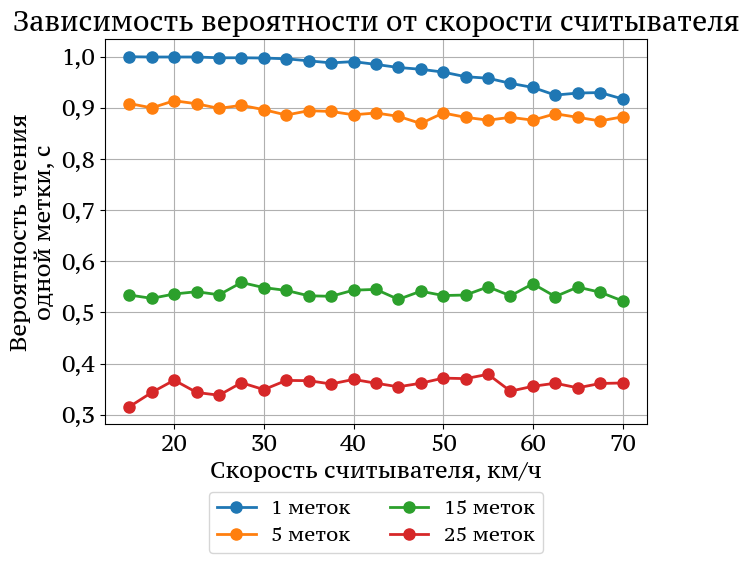

In [21]:
plot_simulations_results(
    results_list=[collision_speed_result["read_user_probs"]],
    labels_list=[key_name(params) for params in tag_period_params],
    titles=["Зависимость вероятности от скорости считывателя"],
    x_variable=speed_variable,
    x_label="Скорость считывателя, км/ч",
    y_label="Вероятность чтения\nодной метки, c",
    image_name="Speed probs collisions",
    save_fig=True,
    image_directory=IMG_DIRECTORY,
)

### 🖼️ Построение графика для времени чтения банка памяти USER

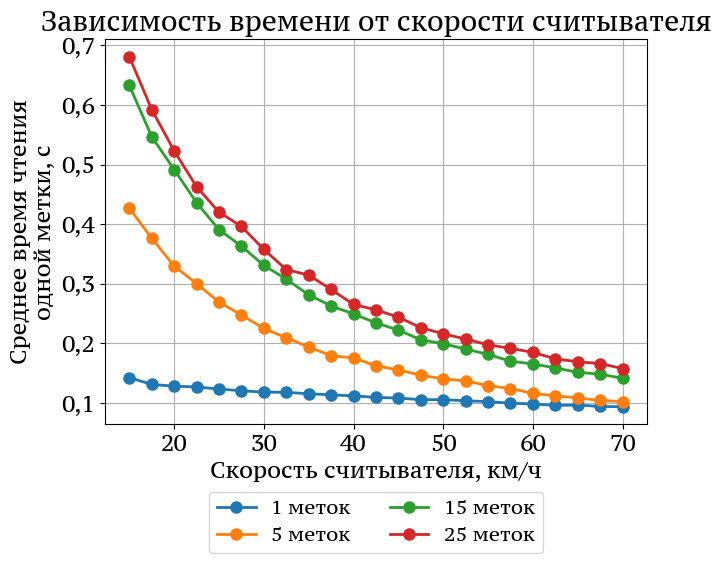

In [22]:
plot_simulations_results(
    results_list=[collision_speed_result["times_count"]],
    labels_list=[key_name(params) for params in tag_period_params],
    titles=["Зависимость времени от скорости считывателя"],
    x_variable=speed_variable,
    x_label="Скорость считывателя, км/ч",
    y_label="Среднее время чтения\nодной метки, c",
    image_name="Speed times collisions",
    save_fig=True,
    image_directory=IMG_DIRECTORY,
)

## 📈 Зависимость вероятности и времени чтения банка памяти `USER` от высоты полёта считывателя

### ⚙️ Параметры для запуска моделирования

In [9]:
# Переменная по оси абсцисс
altitudes = np.arange(1, 6, 0.5)

# Каждый словарь в list - это набор входных данных для одной кривой
altitude_params_list = []
for tag_params_item in tag_period_params:
    altitude_params_list.append({
        "tari": default_params.tari,
        "encoding": default_params.encoding,
        "tid_word_size": default_params.tid_word_size,
        "power": default_params.power_dbm,
        "num_tags": 2000,
        "speed": default_params.speed,
        "reader_offset": default_params.reader_offset,
        "tag_offset": default_params.tag_offset,
        "useadjust": default_params.useadjust,
        "generation_interval": tag_params_item["generation_interval"],
        "label": tag_params_item["label"],
        "q": default_params.q,
    })

### 💾 Получение результатов

In [10]:
collision_altitude_results = calculate_simulations(
    variable="altitude",
    variable_values=altitudes,
    params_list=altitude_params_list,
    key_fn=key_name,
    use_json=USE_JSON,
    save_results=SAVE_RESULTS,
    json_directory=JSON_DIRECTORY,
    file_name="altitude_times_collisions.json"
)
# Моделирование на M3 Pro с "num_tags": 2000:
# Моделирование по переменной altitude: 100%|██████████| 4/4 [05:32<00:00, 83.08s/it]

Моделирование по переменной altitude: 100%|██████████| 4/4 [05:32<00:00, 83.08s/it] 


### 🖼️ Построение графика для вероятности чтения банка памяти USER

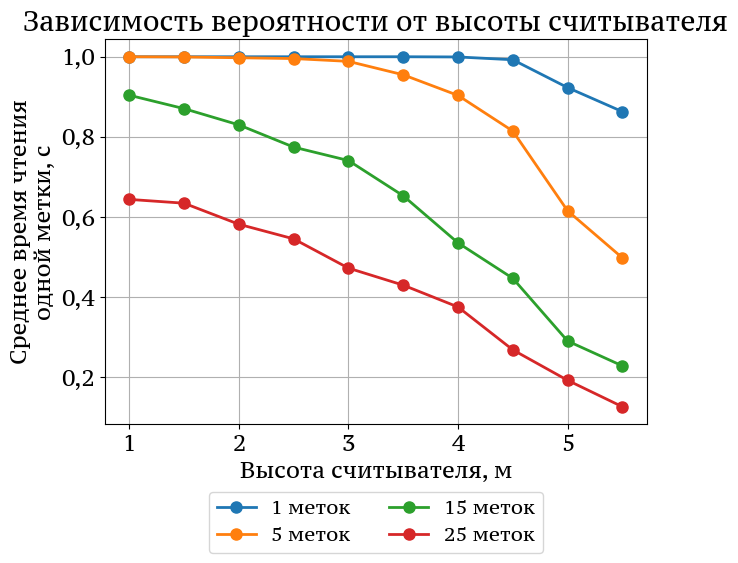

In [23]:
plot_simulations_results(
    results_list=[collision_altitude_results["read_user_probs"]],
    labels_list=[key_name(params) for params in tag_period_params],
    titles=["Зависимость вероятности от высоты считывателя"],
    x_variable=altitudes,
    x_label="Высота считывателя, м",
    y_label="Среднее время чтения\nодной метки, c",
    image_name="Altitude probs collisions",
    save_fig=True,
    image_directory=IMG_DIRECTORY,
)

### 🖼️ Построение графика для времени чтения банка памяти USER

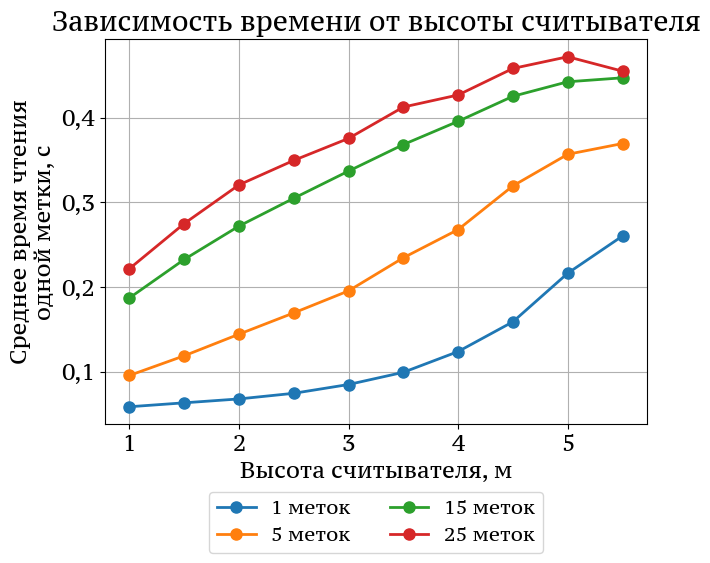

In [24]:
plot_simulations_results(
    results_list=[collision_altitude_results["times_count"]],
    labels_list=[key_name(params) for params in tag_period_params],
    titles=["Зависимость времени от высоты считывателя"],
    x_variable=altitudes,
    x_label="Высота считывателя, м",
    y_label="Среднее время чтения\nодной метки, c",
    image_name="Altitude times collisions",
    save_fig=True,
    image_directory=IMG_DIRECTORY,
)

## 📈 Зависимость вероятности и времени чтения банка памяти `USER` от его величины (в байтах)

### ⚙️ Параметры для запуска моделирования

In [17]:
tid_lengths = list(range(16, 257, 16))

# Каждый словарь в list - это набор входных данных для одной кривой
length_params_list_1_exp = []
for tag_params_item in tag_period_params:
    length_params_list_1_exp.append({
        'tari': default_params.tari,
        'encoding': default_params.encoding,
        "power": default_params.power_dbm,
        'num_tags': 1000, # default_params.num_tags,
        'speed': default_params.speed,
        'reader_offset': default_params.reader_offset,
        'tag_offset': default_params.tag_offset,
        'altitude': 4,
        'useadjust': default_params.useadjust,
        "generation_interval": tag_params_item["generation_interval"],
        "label": tag_params_item["label"],
        'q': default_params.q,
    })

### 💾 Получение результатов

In [18]:
collision_length_results = calculate_simulations(
    variable="tid_word_size",
    variable_values=tid_lengths,
    params_list=length_params_list_1_exp,
    key_fn=key_name,
    use_json=False,
    save_results=True,
    json_directory=JSON_DIRECTORY,
    file_name="length_times_collisions.json"
)
# Моделирование на M3 Pro с "num_tags": 1000:
# Моделирование по переменной tid_word_size:  100%|██████████| 4/4 [03:55<00:00, 58.97s/it]

Моделирование по переменной tid_word_size: 100%|██████████| 4/4 [03:55<00:00, 58.97s/it] 


### 🖼️ Построение графика для вероятности чтения банка памяти USER

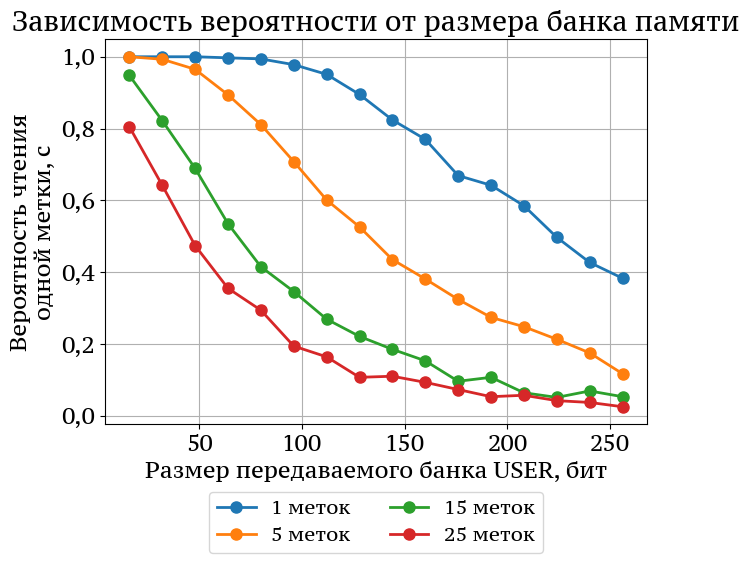

In [19]:
plot_simulations_results(
    results_list=[collision_length_results["read_user_probs"]],
    labels_list=[key_name(params) for params in tag_period_params],
    titles=["Зависимость вероятности от размера банка памяти"],
    x_variable=tid_lengths,
    x_label="Размер передаваемого банка USER, бит",
    y_label="Вероятность чтения\nодной метки, c",
    image_name="Length probs collisions",
    save_fig=True,
    image_directory=IMG_DIRECTORY,
)

### 🖼️ Построение графика для времени чтения банка памяти USER

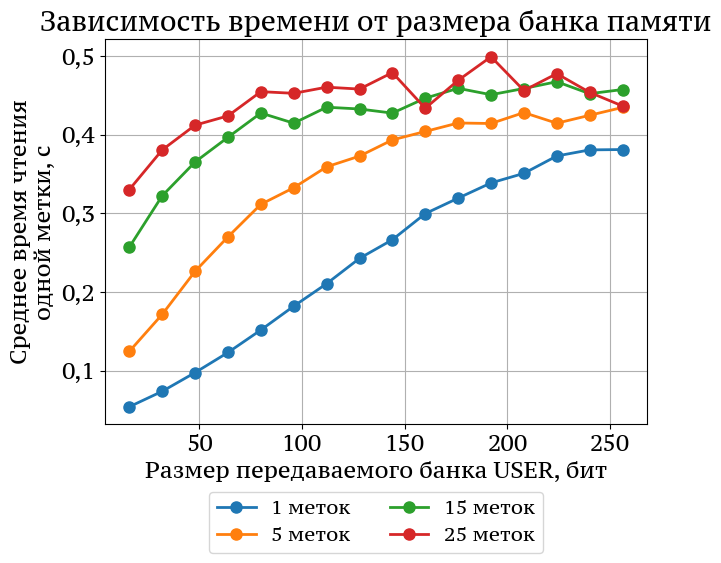

In [20]:
plot_simulations_results(
    results_list=[collision_length_results["times_count"]],
    labels_list=[key_name(params) for params in tag_period_params],
    titles=["Зависимость времени от размера банка памяти"],
    x_variable=tid_lengths,
    x_label="Размер передаваемого банка USER, бит",
    y_label="Среднее время чтения\nодной метки, c",
    image_name="Length times collisions",
    save_fig=True,
    image_directory=IMG_DIRECTORY,
)